<a href="https://colab.research.google.com/github/marketpsych/marketpsych/blob/main/notebooks/aggregate_rmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aggregating Data into Longer Time Windows

This notebook shows how to aggregate MarketPsych's daily data into longer time windows. The latter procedure is interesting particularly when looking for long-term signals, e.g., monthly turnovers or even lower frequencies. In such cases, given that MarketPsych provides data with a daily frequency at its highest latency (other options being hourly and minutely), one needs to aggregate the data into lower-frequency updates. In this notebook, we explore a couple of aggregation options. We also show how one can use the aggregated data to create a financial factor.

---
## 1. Settings
First, we need to install some libraries to obtain MarketPsych's data directly into this notebook. If you need more details about downloading the data, please check out the *load_data* notebook also provided on our GitHub page. Overall, you just need to run the following cells.

In [1]:
import sys
# Installs marketpsych's library into your environment
!{sys.executable} -m pip install marketpsych --upgrade --quiet
# Installs ipywidget library into your environment
!{sys.executable} -m pip install ipywidgets --upgrade --quiet

## Libraries
from marketpsych import sftp
from marketpsych import mpwidgets

# Allows using the widgets
!{sys.executable} -m jupyter nbextension enable --py widgetsnbextension

from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 215kB 29.6MB/s 
     |████████████████████████████████| 256kB 49.1MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 962kB 33.1MB/s 
     |████████████████████████████████| 3.2MB 31.7MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Some standard libraries that are also necessary:

In [2]:
# Standard libraries also necessary
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

!{sys.executable} -m pip install yfinance --upgrade --quiet
import yfinance as yf

     |████████████████████████████████| 6.3MB 27.0MB/s 


In case the standard libraries in the above cell are not installed in your environment, please `pip install` them, for example:

```python
!{sys.executable} -m pip install padas --upgrade --quiet
```

The following widget allows you to easily input your key.
     
<font color='blue'>1. Run the following cell once. After running it, you should see two widgets.</font>  
<font color='blue'>2. Click on the uploader named `Key File` and select your .ppk key.</font>        
<font color='blue'>3. Check if your `User ID` is correct, if not, change it manually.</font>  
<font color='blue'>4. Move on to the next cell.</font> 

In [3]:
cwdgts = mpwidgets.LoginWidgets()
cwdgts.display()

In [4]:
# Creates client
client = sftp.connect(user=cwdgts.id_widget.value, key=cwdgts.key_widget.content)

### 1.2 Loading the data

#### RMA

Let's download the files directly into a pandas dataframe. In this example, we will look into some of the most traded metals, which are available in the `COM_ENM` package. You can easily adapt this example to your use case by selecting another set of assets as available in your trial/subscription. Note, however, that downloading `CMPNY` data can take +100Gb of memory. Hence, if you are working with the `CMPNY` class, we strongly recommend you download the data to your disk. The same for long time-windows and for the minutely/hourly data. Please check the documentation of the `client.download` function below to learn how to do it.

In [5]:
########## INPUTS ########
assetClass = 'COM_ENM'
frequency  = 'WDAI_UDAI'
start_date = datetime.datetime(2016, 1, 1)
end_date   = datetime.datetime(2020, 12, 31)

In [6]:
%%time

rma = client.download(
    asset_class=sftp.AssetClass[assetClass],
    frequency=sftp.Frequency[frequency],
    start=start_date,
    end=end_date,
    trial=True
)

display(rma)

,id,assetCode,windowTimestamp,dataType,systemVersion,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,supplyVsDemandForecast,newExploration,safetyAccident,futureVsPast
0,mp:2016-01-01_20.30.00.News.COM_ENM.ALU,ALU,2016-01-01 20:30:00+00:00,News,MP:4.0.0,46,302.5,-0.158678,0.391736,0.233058,0.029752,0.016529,NaN,NaN,-0.013223,NaN,0.009917,0.013223,0.026446,0.018182,0.009917,0.003306,0.013223,NaN,0.424793,-0.023140,-0.003306,NaN,NaN,NaN,NaN,NaN,-0.013223,NaN,0.019835,NaN,NaN,NaN,0.018182,NaN,NaN,NaN,-0.527273
1,mp:2016-01-01_20.30.00.News_Social.COM_ENM.ALU,ALU,2016-01-01 20:30:00+00:00,News_Social,MP:4.0.0,64,491.0,-0.101833,0.323829,0.221996,0.018330,0.031568,NaN,NaN,-0.008147,NaN,0.000000,0.009165,0.032587,0.019348,0.014257,0.002037,0.022403,NaN,0.401222,-0.030550,0.002037,0.002037,NaN,NaN,NaN,NaN,-0.024440,NaN,0.024440,NaN,NaN,NaN,0.039715,NaN,NaN,NaN,-0.445010
2,mp:2016-01-01_20.30.00.News_Headline.COM_ENM.ALU,ALU,2016-01-01 20:30:00+00:00,News_Headline,MP:4.0.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000
3,mp:2016-01-01_20.30.00.Social.COM_ENM.ALU,ALU,2016-01-01 20:30:00+00:00,Social,MP:4.0.0,18,188.5,-0.010610,0.214854,0.204244,NaN,0.055703,NaN,NaN,NaN,NaN,-0.015915,0.002653,0.042440,0.021220,0.021220,0.000000,0.037135,NaN,0.363395,-0.042440,0.010610,0.005305,NaN,NaN,NaN,NaN,-0.042440,NaN,0.031830,NaN,NaN,NaN,0.074271,NaN,NaN,NaN,-0.312997
4,mp:2016-01-01_20.30.00.News.COM_ENM.ANGS,ANGS,2016-01-01 20:30:00+00:00,News,MP:4.0.0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263083,mp:2020-12-31_20.30.00.Social.COM_ENM.USCRU,USCRU,2020-12-31 20:30:00+00:00,Social,MP:4.0.0,1118,4281.6,0.084081,0.180306,0.264387,0.053251,0.051149,0.026158,0.007941,0.016583,0.006540,-0.001868,0.003737,0.038771,0.047879,0.007707,-0.007240,0.021861,0.014247,0.501588,0.003270,-0.019619,0.000934,-0.001635,0.001401,NaN,-0.000234,-0.004438,-0.001868,0.015415,0.000467,-0.000934,NaN,0.003970,-0.004905,0.000467,NaN,-0.083520
263084,mp:2020-12-31_20.30.00.News.COM_ENM.ZNC,ZNC,2020-12-31 20:30:00+00:00,News,MP:4.0.0,82,267.7,0.220396,0.115801,0.336197,0.127008,0.041091,NaN,NaN,0.041091,NaN,-0.011207,NaN,0.014942,0.007471,NaN,-0.056033,-0.014195,NaN,0.215540,-0.065372,0.003736,NaN,NaN,NaN,NaN,NaN,-0.022413,NaN,0.011207,NaN,0.014942,NaN,0.014942,0.022413,0.007471,NaN,-0.222264
263085,mp:2020-12-31_20.30.00.News_Social.COM_ENM.ZNC,ZNC,2020-12-31 20:30:00+00:00,News_Social,MP:4.0.0,148,444.9,0.168577,0.148348,0.316925,0.101146,0.049449,0.011238,0.002248,0.024725,0.004495,-0.002248,0.002248,0.029220,0.038211,0.002248,-0.017982,0.003147,0.005619,0.405484,-0.034839,-0.035963,-0.013486,NaN,NaN,NaN,NaN,-0.015734,NaN,0.010115,NaN,0.008991,NaN,0.008991,0.013486,0.004495,NaN,-0.102270
263086,mp:2020-12-31_20.30.00.News_Headline.COM_ENM.ZNC,ZNC,2020-12-31 20:30:00+00:00,News_Headline,MP:4.0.0,2,6.0,0.333333,NaN,0.333333,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.166667,NaN,NaN,NaN,0.333333,NaN,0.333333,0.333333,NaN,NaN,1.000000


CPU times: user 6.37 s, sys: 548 ms, total: 6.92 s
Wall time: 18.7 s


Let's now slice the dataframe such that we only keep the commodities of interest and the data points from News sources:

In [7]:
dataType = 'News'
assetCodes = ['SLVR', 'CPPR', 'PALL', 'PLAT'] 

# Slices DF to only keep assets of interest and dataType selection
rma.query(f"assetCode in {assetCodes} & dataType == '{dataType}'", inplace=True)
# Converts time to datetime format
rma.windowTimestamp = pd.to_datetime(pd.to_datetime(rma.windowTimestamp).dt.strftime('%Y-%m-%d'))

rma.head()

,id,assetCode,windowTimestamp,dataType,systemVersion,mentions,buzz,sentiment,negative,positive,optimism,pessimism,joy,loveHate,trust,anger,disagreement,fear,gloom,stress,surprise,timeUrgency,uncertainty,violence,emotionVsFact,shortVsLongTerm,longShort,longShortForecast,priceDirection,priceDown,priceForecast,priceUp,topVsBottom,overvaluedVsUndervalued,volatility,consumptionVolume,productionVolume,regulatoryIssues,supplyVsDemand,supplyVsDemandForecast,newExploration,safetyAccident,futureVsPast
32,mp:2016-01-01_20.30.00.News.COM_ENM.CPPR,CPPR,2016-01-01,News,MP:4.0.0,109,447.5,-0.317318,0.455866,0.138547,0.020112,0.015642,NaN,NaN,-0.002235,NaN,0.006704,NaN,0.031285,0.040223,-0.001117,-0.021229,0.004469,0.017877,0.491620,-0.093855,0.006704,NaN,NaN,NaN,NaN,NaN,-0.011173,0.002235,0.021229,0.006704,-0.008939,NaN,-0.022346,-0.008939,0.002235,NaN,-0.586592
100,mp:2016-01-01_20.30.00.News.COM_ENM.PALL,PALL,2016-01-01,News,MP:4.0.0,20,92.0,-0.173913,0.271739,0.097826,0.054348,0.010870,NaN,NaN,-0.021739,NaN,-0.021739,0.043478,0.141304,NaN,NaN,-0.043478,NaN,NaN,0.478261,-0.076087,NaN,NaN,NaN,NaN,NaN,NaN,-0.021739,-0.021739,NaN,NaN,NaN,NaN,-0.065217,-0.043478,NaN,NaN,-0.347826
104,mp:2016-01-01_20.30.00.News.COM_ENM.PLAT,PLAT,2016-01-01,News,MP:4.0.0,27,154.5,-0.498382,0.543689,0.045307,NaN,0.048544,NaN,NaN,0.006472,NaN,0.000000,NaN,0.097087,0.012945,NaN,-0.084142,NaN,0.006472,0.663430,-0.038835,NaN,NaN,NaN,NaN,NaN,NaN,-0.006472,NaN,NaN,NaN,NaN,NaN,0.045307,0.012945,NaN,NaN,-0.779935
120,mp:2016-01-01_20.30.00.News.COM_ENM.SLVR,SLVR,2016-01-01,News,MP:4.0.0,106,208.5,-0.043165,0.163070,0.119904,0.047962,0.047962,NaN,NaN,0.009592,NaN,-0.004796,NaN,0.028777,0.033573,NaN,-0.033573,NaN,0.004796,0.016787,-0.122302,-0.023981,NaN,-0.023981,0.028777,0.004796,0.004796,0.023981,0.004796,0.004796,NaN,NaN,NaN,-0.002398,NaN,NaN,NaN,-0.424460
176,mp:2016-01-02_20.30.00.News.COM_ENM.CPPR,CPPR,2016-01-02,News,MP:4.0.0,54,108.0,0.185185,0.129630,0.314815,NaN,NaN,NaN,NaN,0.083333,NaN,-0.083333,NaN,0.055556,0.037037,NaN,-0.046296,NaN,NaN,0.675926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.111111,NaN,0.138889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.574074


#### Price

Given the simplicity of this example, we download price data from Yahoo finance, which is an easily accessible library. Specifically, we'll be looking at some liquid ETFs tracking the metals that we are analyzing. That is to avoid having to deal with the rolling of contracts.

In [8]:
tickers = ['SLV', 'CPER', 'PPLT', 'PALL']

# The extra days at the end are to have the last forward month
prices = yf.download(tickers, progress=False,
            start=start_date, end=end_date+datetime.timedelta(days=40))
# We are only interested in the Closing prices:
prices = prices['Adj Close']

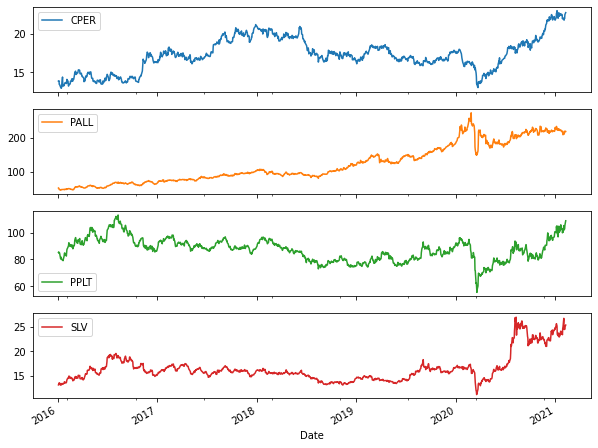

In [9]:
prices.plot(subplots=True, figsize=(10, 8))
plt.show()

Now we compute forward returns. To be sure we are not introducing some look-ahead bias, let's use the returns from close to close on the first day of trade for each (forward) month.

In [10]:
fw_mon_rets = ((prices.resample('M').first().shift(-1)
               / prices.resample('M').first()) - 1).shift(-1)

# Converts to format/column names that can be easily merged with sentiment df
fw_mon_rets = fw_mon_rets.unstack().reset_index()
fw_mon_rets.columns = ['assetCode', 'windowTimestamp', 'fwRet']

#### Final touch

Finally, to have both RMA and price data with the same codes, we rename the assetCode in the RMA dataframe. If you are working with `CMPNY`, assetCode refers to the PermID of a company. A mapping from PermIDs to your trading universe will be needed to track companies to their stock price.

In [11]:
convert_assetCode = {
    'SLVR':'SLV',
    'CPPR':'CPER',
    'PLAT':'PPLT',
    'PALL':'PALL'
}

rma['assetCode'] = rma['assetCode'].replace(convert_assetCode)

In this example, let's choose a common topic in news about commodities, the level of supply and demand, as proxied by the `supplyVdDemand` RMA. The higher the value of this RMA, the more overwhelming the news are about oversupply/weak demand. While low values indicate more demand / less supply.

In [12]:
rma_score = 'supplyVsDemand'

## 2. Aggregation

### 2.1 Simple average

Now, let's assume we want to develop a strategy with a monthly turnover based on one of the RMAs. In that scenario, we may want to aggregate all information in-between the trades, i.e., to create a monthly sentiment value. There are a few routes we can take here. The simplest one is to average the level of sentiment:

$$
s_m^\text{Avg} = \frac{1}{D}\sum_{d \in m}^D s_d \label{eq1}\tag{1} 
$$

where $s_d$ is the daily ($d$) RMA value in month $m$.  

In [13]:
#### Approach 1
sent = rma.set_index('windowTimestamp')\
        .groupby(["assetCode", pd.Grouper(freq="M")])\
            [rma_score].mean().reset_index().rename(columns={rma_score : 'sentAvg'})

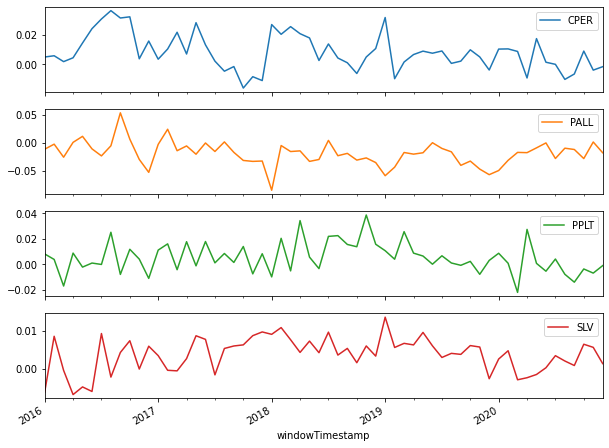

In [14]:
sent.pivot_table(columns='assetCode', 
                 index='windowTimestamp', 
                 values='sentAvg').plot(subplots=True, figsize=(10, 8))
plt.show()

### 2.2. Buzz-weighting
One note with the approach in Eqn. 1 is that we treat all daily values as equal, even though the news may be considerably more/less populated on some days. An alternative is to re-aggregate the data (thus buzz-weighting it) such that we have a monthly RMA rather than a daily one:

$$
s_m^\text{Bw} = \frac{\sum_{d \in m}^D s_d b_d}{\sum_{d \in m}^D b_d} \label{eq2}\tag{2} 
$$

We use the Bw subscript to describe "buzz-weighted" as this is effectively the difference from the simple average approach.

In [15]:
#### Approach 2
temp = rma.set_index('windowTimestamp').copy()
temp['sentBuzz'] =  temp[rma_score] * temp["buzz"]
temp = temp.groupby(["assetCode", pd.Grouper(freq="M")])[['sentBuzz', 'buzz']].sum()
# The above lines obtain the numerator and denominator of the equation
temp = (temp.sentBuzz / temp.buzz).reset_index().rename(columns={0: 'sentBw'})

# Merges both time-series
sent = sent.merge(temp)

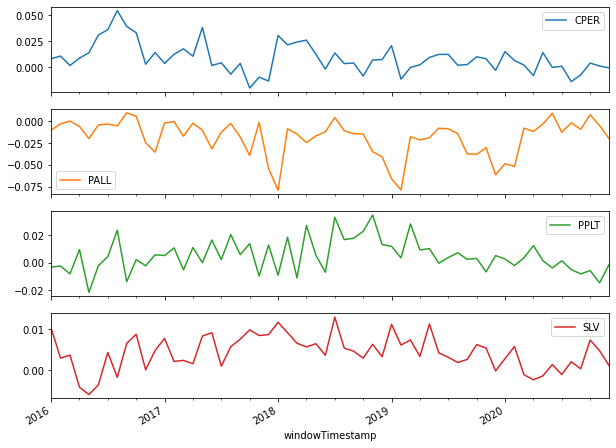

In [16]:
sent.pivot_table(columns='assetCode', 
                 index='windowTimestamp', 
                 values='sentBw').plot(subplots=True, figsize=(10, 8))
plt.show()

Despite the difference in methodologies, both approaches will generally yield similar results, especially for assets with a high volume of news. This is confirmed when looking at the correlations between both approaches:

In [17]:
sent.groupby('assetCode')[['sentAvg', 'sentBw']].corr()

sentAvg    sentBw
assetCode                            
CPER      sentAvg  1.000000  0.948261
          sentBw   0.948261  1.000000
PALL      sentAvg  1.000000  0.748979
          sentBw   0.748979  1.000000
PPLT      sentAvg  1.000000  0.830589
          sentBw   0.830589  1.000000
SLV       sentAvg  1.000000  0.778414
          sentBw   0.778414  1.000000

## 3. Creating a factor with the aggregated RMA

Lets merge both (RMA and price) datasets.

In [18]:
sent_comb = sent.merge(fw_mon_rets, on=['assetCode', 'windowTimestamp'])

Now that we have both sentiment and forward returns in the same DF, we can analyze some simple strategies. For example, we can hypothesize that relative price movements of commodities are somewhat related to how the market notices the disparity between supply and demand. Let's thus try the following arbitrage:

- Based on the past month's level of the `supplyVsDemand` RMA we:
    - Buy the commodity (ETF) with the lowest value (high Demand / low Supply)
    - Short the commodity (ETF) with the highest value (low Demand / high Supply)
    
The approach is similar to the identification of risk factors. In such cases, one may be looking into a large number of assets in each portfolio. To generalize, we will create two new columns in the dataframe, which will hold the cross-sectional percentile rank of each commodity's `supplyVsDemand`.

In [19]:
sent_comb['sentAvg_rank'] = sent_comb.groupby('windowTimestamp')['sentAvg'].rank(pct=True)
sent_comb['sentBw_rank'] = sent_comb.groupby('windowTimestamp')['sentBw'].rank(pct=True)
# Reorders the DF for easiness of visualization
sent_comb = sent_comb.sort_values(by=['windowTimestamp', 'assetCode']).reset_index(drop=True)
sent_comb.head()

,assetCode,windowTimestamp,sentAvg,sentBw,fwRet,sentAvg_rank,sentBw_rank
0,CPER,2016-01-31,0.004984,0.008321,0.041545,0.75,0.75
1,PALL,2016-01-31,-0.011595,-0.010127,0.023682,0.25,0.25
2,PPLT,2016-01-31,0.008025,-0.003108,0.078289,1.00,0.50
3,SLV,2016-01-31,-0.006212,0.010315,0.036576,0.50,1.00
4,CPER,2016-02-29,0.005826,0.010864,0.008397,0.75,1.00


In [20]:
colors = {'SLV': 'grey', 
          'CPER': '#B87333',
          'PPLT': 'blue',
          'PALL':'black'}

def portfolios_plot(low_df, top_df):
    fig = plt.figure(figsize=(16, 7))
    gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

    ax1 = fig.add_subplot(gs[:, 0])
    low_rets = low_df.groupby('windowTimestamp')['fwRet'].mean()
    top_rets = top_df.groupby('windowTimestamp')['fwRet'].mean()
    spread_rets = low_rets - top_rets
    
    (low_rets + 1).cumprod().plot(c='g', ax=ax1)
    (top_rets + 1).cumprod().plot(c='r', ax=ax1)
    (spread_rets + 1).cumprod().plot(c='b', ls='--', ax=ax1)
    ax1.set_ylabel('Dollar growth')
    ax1.legend(['Long', 'Short', 'Spread'])
    ax1.set_title(f'Spread: $\mu$={spread_rets.mean():.2%}, \
$\sigma$={spread_rets.std() * math.sqrt(12):.2%}')

    ax2 = fig.add_subplot(gs[0, 1])
    low_df.assetCode.value_counts().plot.barh(ax=ax2, 
        color=[colors[c] for c in low_df.assetCode.value_counts().index])
    ax2.set_ylabel('Long', color='g')

    ax3 = fig.add_subplot(gs[1, 1])
    top_df.assetCode.value_counts().plot.barh(ax=ax3,
        color=[colors[c] for c in top_df.assetCode.value_counts().index])
    ax3.set_ylabel('Short', color='r')

    plt.show()

simple average


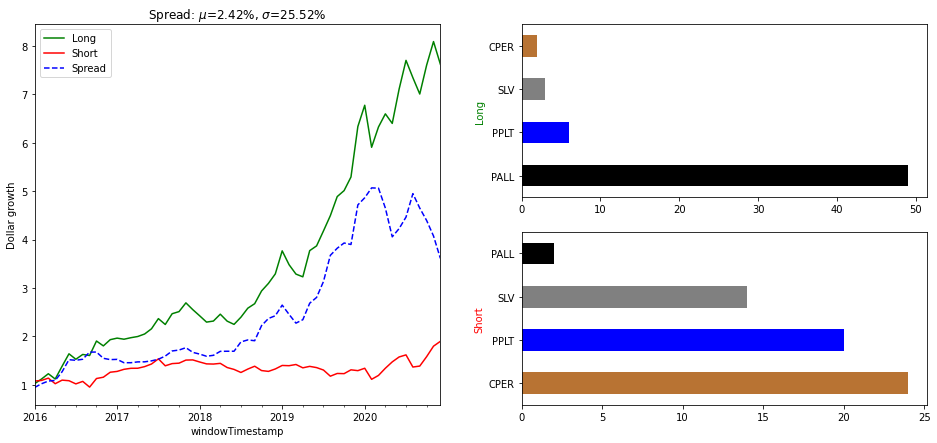

buzz-weighted


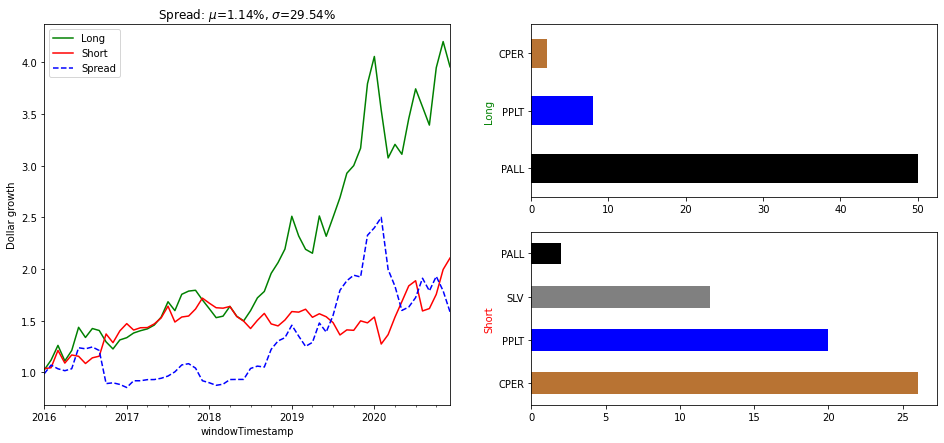

In [21]:
low_thresh = 0.25
top_thresh = 0.75

print('simple average')
low_df = sent_comb[sent_comb['sentAvg_rank'] <= low_thresh]
top_df = sent_comb[sent_comb['sentAvg_rank'] >  top_thresh]
portfolios_plot(low_df, top_df)

print('buzz-weighted')
low_df = sent_comb[sent_comb['sentBw_rank'] <= low_thresh]
top_df = sent_comb[sent_comb['sentBw_rank'] >  top_thresh]
portfolios_plot(low_df, top_df)

As we observe above, the trends look similar in both versions, as expected by the high correlations. Yet, the result can be quite different, but that is mostly an effect of the highly concentrated portfolios (one ETF at a time in each only). It’s easy to notice that silver never made the long portfolio in the buzz-weighted aggregation.

## 4. Conclusions

We have shown two examples of how to aggregate the daily data into longer time-intervals. We also demonstrate how to create a simple factor from RMAs. 